## MultiAgent system
### Configure the model

In [27]:
from dotenv import load_dotenv
import os
from langchain_openai import ChatOpenAI

load_dotenv()

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
llm = ChatOpenAI(model="gpt-4o")

### example of using Command and transfering cursor

In [28]:
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent

def add_number(state):
    result = state["num1"] + state["num2"]
    print(f"addition is {result}")
    return Command(goto="multiply", update={"sum": result})

state={"num1":10,"num2":20}
add_number(state)

addition is 30


Command(update={'sum': 30}, goto='multiply')

### Creating a Dummy Multiagent

This is a network/collab multiagent

In [29]:
from langchain_core.tools import tool

@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help"""
    return
@tool
def transfer_to_addition_expert():
    """Ask addition agent for help"""
    return

### Example of how this tool will work after binding it to llm

In [30]:
llm_with_tools = llm.bind_tools([transfer_to_addition_expert])

response = llm_with_tools.invoke("what is 56 + 20?")
print("content:" + response.content)
response.pretty_print()

content:
================================== Ai Message ==================================
Tool Calls:
  transfer_to_addition_expert (call_mvTZVb7PFUXbg6D2t28nK2kS)
 Call ID: call_mvTZVb7PFUXbg6D2t28nK2kS
  Args:


### 🔹 Command[...] (Generic Type)
Command is a generic class or type — often used in frameworks related to agents, workflows, or tool-chaining (like LangChain, OpenAI Functions, etc.).
It represents a structured instruction or command returned by an expert or step in a decision-making process.

### 🔹 Literal[...]
Literal is from Python's typing module (Python 3.8+). It restricts values to a specific set of string (or other primitive) constants.

### Literal["multiplication_expert", "_end_"]
This means the return value must only be one of:

"multiplication_expert" — likely a signal to transition to another expert/module.

"_end_" — likely a signal that the workflow should terminate.

### Command[Literal["multiplication_expert", "_end_"]]
means the function addition_expert returns a Command object, and that command must instruct either:

to move control to "multiplication_expert", or

to signal "_end_", finishing the workflow.





In [31]:
from typing_extensions import Literal
from langgraph.graph import MessagesState,StateGraph, START,END

#Agent 1
def addition_expert(state:MessagesState)-> Command[Literal["multiplication_expert","__end__"]]:
    system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]

    ai_msg = llm.bind_tools([transfer_to_multiplication_expert]).invoke(messages)

    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id
        }

        return Command(goto="multiplication_expert", update={"messages": [ai_msg, tool_msg]})
    return Command(goto="__end__", update={"messages": [ai_msg]})


#Agent2
def multiplication_expert(state:MessagesState) -> Command[Literal["addition_expert", "__end__"]]:
    system_prompt = (
        "You are a multiplication expert, you can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]

    ai_msg = llm.bind_tools([transfer_to_addition_expert]).invoke(messages)

    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id
        }
        return Command(goto="addition_expert", update={"messages": [ai_msg, tool_msg]})
    return Command(goto="__end__", update={"messages": [ai_msg]})


### Creating the Workflow

In [32]:
graph=StateGraph(MessagesState)
graph.add_node("addition_expert",addition_expert)
graph.add_node("multiplication_expert",multiplication_expert)
graph.add_edge(START, "addition_expert")
app=graph.compile()

In [33]:
app.invoke({"messages":[("user","what's (3 + 5). In the result multiply with 10")]})

{'messages': [HumanMessage(content="what's (3 + 5). In the result multiply with 10", additional_kwargs={}, response_metadata={}, id='da2f09cb-8df0-4491-a4d4-c4f455043913'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_d00ZInmPe79ehbl2qr5I8VrI', 'function': {'arguments': '{}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 85, 'total_tokens': 118, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BlsflXsHSHt7ylJ0Z9XYsQTBUmvgm', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--afc3d75c-dd9f-4e4e-918d-706bc54aa084-0', tool_calls=[{'name': 'transfer_to_multiplication_exper

### Multiagent with Realtime tool
Configuring Tavily(for web search) and Python Repl tool (to execute code)

In [35]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.utilities import PythonREPL

TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)

repl=PythonREPL()
code = """
x = 5
y = x * 2
print(y)
"""
repl.run(code)

C:\Users\aayushisharma\AppData\Local\Temp\ipykernel_18976\1818617447.py:6: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)
Python REPL can execute arbitrary code. Use with caution.


'10\n'

In [40]:
from typing import Annotated

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

print(python_repl_tool)

print(python_repl_tool.invoke(code))

name='python_repl_tool' description='Use this to execute python code. If you want to see the output of a value,\n    you should print it out with `print(...)`. This is visible to the user.' args_schema=<class 'langchain_core.utils.pydantic.python_repl_tool'> func=<function python_repl_tool at 0x000002C5FA85E020>
Successfully executed:
\`\`\`python

x = 5
y = x * 2
print(y)

\`\`\`
Stdout: 10


If you have completed all tasks, respond with FINAL ANSWER.


In [39]:
def make_system_prompt(instruction:str)->str:
    return  (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{instruction}"
    )

make_system_prompt("You can only do research. You are working with a chart generator colleague.")

"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

### Creating the Node and Workflow

In [52]:
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import MessagesState,StateGraph, START, END

def get_next_node(last_message:BaseMessage, goto:str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

#Agent 1
def research_node(state:MessagesState)->Command[Literal["chart_generator", END]]:
    research_agent=create_react_agent(
        llm,
        tools=[search_tool],
        prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ), 
        )
    
    result=research_agent.invoke(state)
    goto=get_next_node(result["messages"][-1],"chart_generator")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")
    return Command(update={"messages": result["messages"]},goto=goto)


#Agent 2
def chart_node(state:MessagesState)-> Command[Literal["researcher", END]]:
    chart_agent=create_react_agent(
        llm,
        tools=[python_repl_tool],
        prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
        )
    result=chart_agent.invoke(state)
    goto=get_next_node(result["messages"][-1],"researcher")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chart_generator")
    return Command(update={"messages": result["messages"]},goto=goto)


#workflow
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
app = workflow.compile()

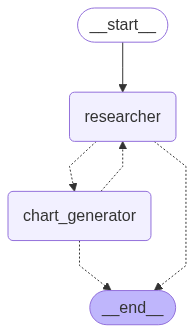

In [53]:
workflow.compile()

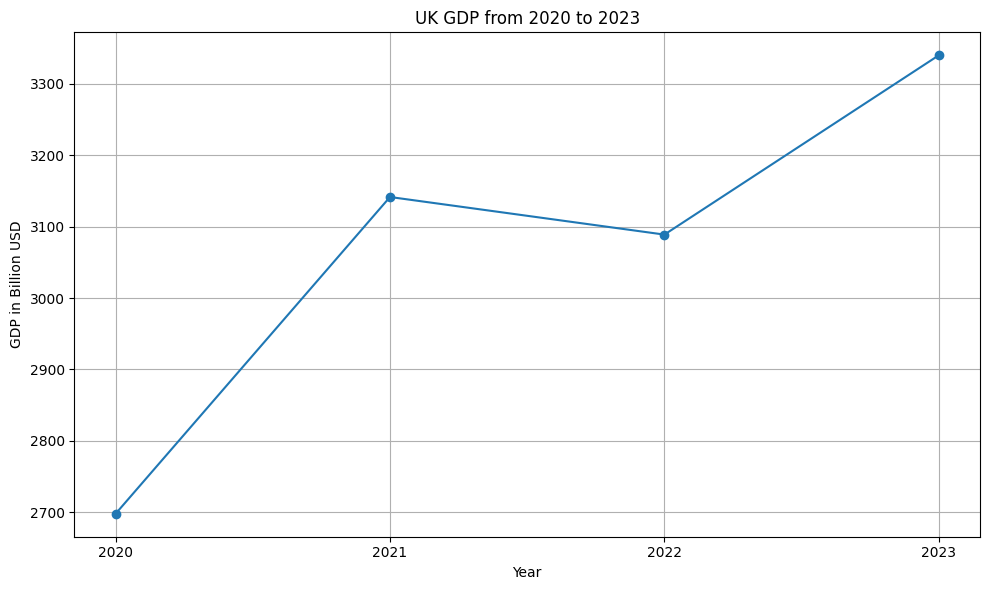

{'messages': [HumanMessage(content="get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='41a6ca1c-fa1b-4f89-a485-0144adac2906'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8y00qS7jQLMs4tdWobn357kc', 'function': {'arguments': '{"query": "UK GDP 2020"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_s1zLmmIDPCnJ6nNJ87yn1J74', 'function': {'arguments': '{"query": "UK GDP 2021"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_qzxsZWOfgV1opTGrq0BbKH57', 'function': {'arguments': '{"query": "UK GDP 2022"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 205, 'total_tokens': 287, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_toke

In [54]:
app.invoke({"messages": [("user","get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.")],})